In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

raw_dataset = pd.read_csv("./ratings.csv")
raw_dataset.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


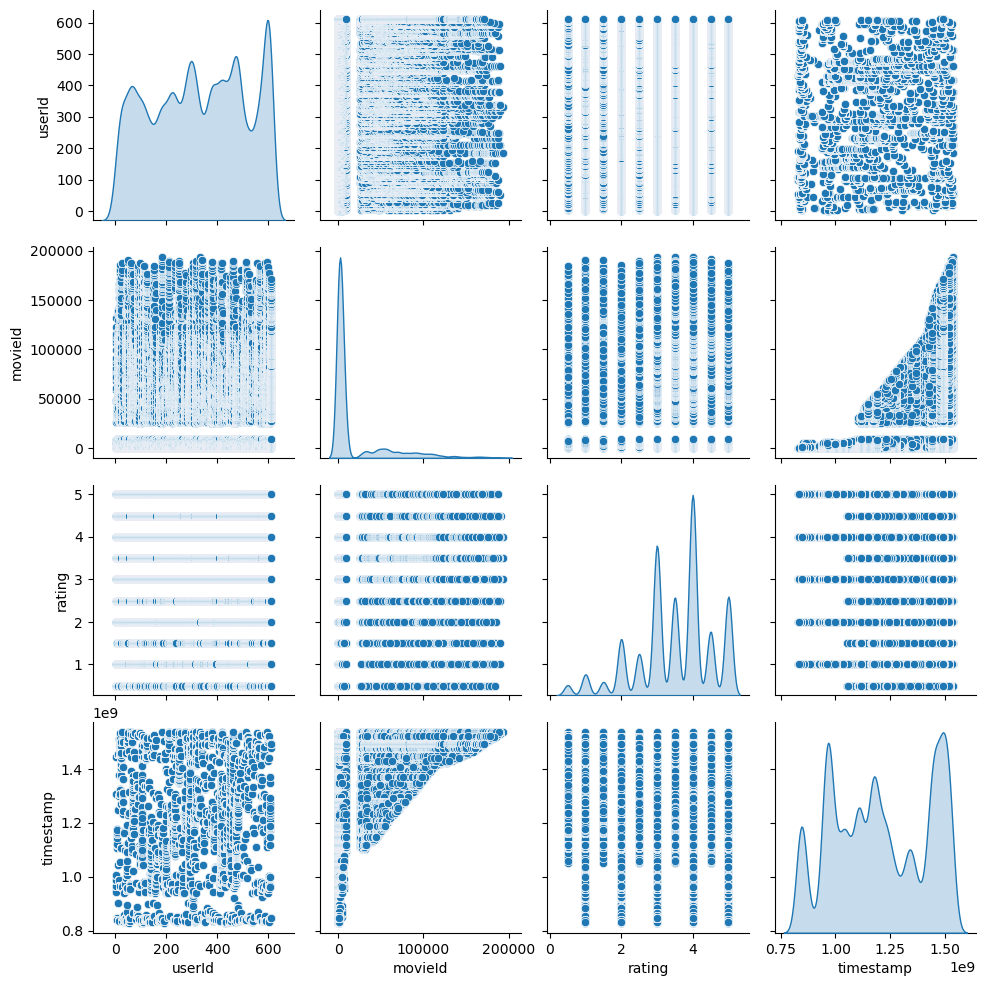

In [2]:
import seaborn
seaborn.pairplot(raw_dataset, diag_kind='kde')


In [3]:
raw_dataset.nunique()

userId         610
movieId       9724
rating          10
timestamp    85043
dtype: int64

In [4]:
codes_movies, uniques_movies = pd.factorize(raw_dataset['movieId'])
codes_users, uniques_users = pd.factorize(raw_dataset['userId'])
ratings = raw_dataset['rating'].values
Y = np.zeros((len(uniques_movies), len(uniques_users)))
Y[codes_movies, codes_users] = raw_dataset['rating'].values
R = Y > 0
Ymean = np.sum(Y, axis=1) / np.sum(R,axis=1)
Ynorm = Y - Ymean.reshape(-1,1)


# Following section is just copypasted from lab

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# from recsys_utils import *

def cofi_cost_func_v(X, W, b, Y, R, lambda_):
    """
    Returns the cost for the content-based filtering
    Vectorized for speed. Uses tensorflow operations to be compatible with custom training loop.
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)*R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J


#  Useful Values
num_movies, num_users = Y.shape
num_features = 100

# Set Initial Parameters (W, X), use tf.Variable to track these variables
tf.random.set_seed(1234)  # for consistent results
W = tf.Variable(tf.random.normal((num_users,  num_features), dtype=tf.float64),  name='W')
X = tf.Variable(tf.random.normal((num_movies, num_features), dtype=tf.float64),  name='X')
b = tf.Variable(tf.random.normal((1,          num_users),    dtype=tf.float64),  name='b')

# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-1)
iterations = 200
lambda_ = 1
for iter in range(iterations):
    # Use TensorFlow’s GradientTape
    # to record the operations used to compute the cost
    with tf.GradientTape() as tape:

        # Compute the cost (forward pass included in cost)
        cost_value = cofi_cost_func_v(X, W, b, Ynorm, R, lambda_)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss
    grads = tape.gradient(cost_value, [X, W, b])

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, [X, W, b]))

    # Log periodically.
    if iter % 20 == 0:
        print(f"Training loss at iteration {iter}: {cost_value:0.1f}")


Training loss at iteration 0: 5682614.1
Training loss at iteration 20: 286694.3
Training loss at iteration 40: 110541.2
Training loss at iteration 60: 54240.3
Training loss at iteration 80: 31074.9
Training loss at iteration 100: 19888.8
Training loss at iteration 120: 13866.1
Training loss at iteration 140: 10393.9
Training loss at iteration 160: 8296.7
Training loss at iteration 180: 6984.7


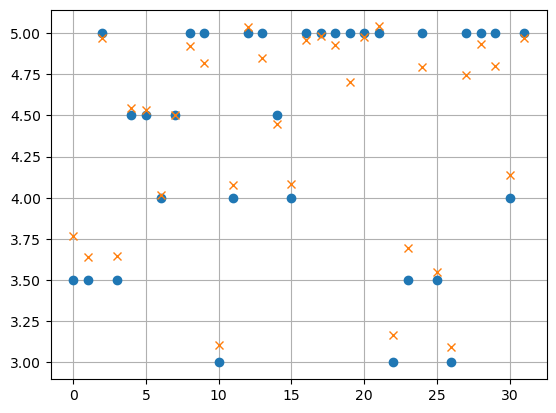

In [6]:
from matplotlib import pyplot as plt
random_dudes_weights = W.numpy()[11]
random_dudes_biases = b.numpy()[0, 11]
random_dudes_predictions = np.dot(X.numpy(), random_dudes_weights) + random_dudes_biases + Ymean
random_dudes_voted_ids = [i for i in range(num_movies) if R[i,11] == True]
random_dudes_votes = Y[random_dudes_voted_ids, 11]
plt.plot(random_dudes_votes, 'o')
plt.plot(random_dudes_predictions[random_dudes_voted_ids], 'x')
plt.grid()
